In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import sys
print(sys.version)

3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn, scipy#missingno, lightgbm, xgboost
%matplotlib inline

# 문제 이해
## 제목 : Spotify Popularity Prediction
## 미션 : 
## 문제유형 : 회귀 분석
## 평가지표 : RMSE=np.sqrt(1/𝑁∗∑(-1**𝑁*(𝑌_𝑖 − Y_hat_𝑖)**2)

* id: Spotify 데이터베이스의 노래 식별자
* artists: 아티스트 이름
* name: 노래 이름
* year: 출시 연도
* release_date: 연-월-일로 인코딩된 노래 출시 날짜입니다. 그러나 모든 노래에 완전한 정보가 있는 것은 아니므로 예를 들어 연도만 포함할 수도 있습니다.
* acousticness: 0에서 1 사이로, 음악의 음향 (반주구간) 정도를 나타냅니다.
* danceability: 0에서 1 사이의 값으로, 노래가 얼마나 춤추는지 나타냅니다.
* duration_ms: 밀리초 단위의 기간입니다.
* energy: 0과 1 사이의 음악이 얼마나 에너지 넘치는지 나타냅니다.
* explicit: 노래에 노골적인 내용의 가사가 포함되어 있으면 1, 그렇지 않으면 0입니다.
* instrumentalness: 0에서 1 사이, 노래가 얼마나 중요한지 나타냅니다.
* key: 여기에 매핑된 노래 톤.
* liveness: 0과 1 사이, 노래가 얼마나 "라이브"되는지
* loudness: 음악의 크기를 나타냅니다. 값은 일반적으로 음악의 데시벨 수를 나타내는 -60에서 0 사이입니다.
* mode: 노래가 장조이면 1, 단조이면 0입니다. 일반적으로 장조의 노래는 행복한 노래로 간주되는 반면 단조의 노래는 더 슬픈 노래로 간주됩니다.
* speechiness: 0에서 1 사이, 노래가 얼마나 발성/발성되는지(육성으로 노래하는 시간)를 나타냅니다.
* tempo: BPM(분당 비트 수)으로 표시되는 노래 템포
* valence: 0과 1 사이로 노래의 긍정성을 설명하며, 긍정적인 노래(행복, 즐거운, 행복감 등)에 대한 높은 값과 부정적인 노래(슬픔, 분노 등)에 대한 낮은 값으로 나타냅니다.
* popularity: 0에서 100 사이의 노래 인기도입니다. 이 세트에서는 이것이 목표 변수입니다.

인기도와 뭘 비교할까...

# EDA
## 데이터 둘러보기(구조 탐색)
- 파일별 용도 파악
- 데이터 양(레코드 수, 피처 수, 전체 용량 등)
- 피처 이해(이름, 의미, 데이터 타입, 결측값 개수, 고윳값 개수, 실제값, 데이터 종류 등)
- 훈련 데이터와 테스트 데이터 차이
- 타깃값 : 제출(예측)해야 하는 값
## 데이터 시각화
- 각종 시각화
    - 수치 데이터시각화
    - 범주형 데이터 시각화
    - 데이터 관계 시각화
- 피처 파악
    - 추가할 피처
    - 제거할 피처
    - 피처별 인코딩 전략
- 이상치 파악
    - 해당 피처별 처리 방법
    - 결과물 :추가/제거 피처 목록, 인코딩 전략, 이상치 처리 전략

In [6]:
data_path = "/Users/potatodev/Documents/code/DSStudy-sun/jihee/23.10.29./"

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')

In [36]:
train.head()

,id,artists,name,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,release_date,speechiness,tempo,valence,popularity
0,7pQSmQ0l7QdBeL9X6CEMbH,['Erroll Garner'],I'll Remember April - Original Edited Concert ...,1955,0.92300,0.438,257693,0.602,0,0.658000,8,0.9500,-14.565,1,1955,0.0408,122.289,0.546,24
1,2g8MTBFRUSFKbY5RQiSSEE,['Maison & Dragen'],Chinese New Year - Radio Edit,2014,0.00019,0.477,193968,0.834,0,0.978000,4,0.3960,-6.534,0,2014-05-02,0.0396,130.007,0.516,0
2,2LcJoQ5SDUZrC2qUjWMEdF,"['Yoel Lerner', 'Mazi Cohen']",השפן הקטן,1981,0.90000,0.617,56827,0.272,0,0.000000,7,0.0879,-16.818,1,1981-04-01,0.0577,83.244,0.807,38
3,6RzHyUtRNARYyn2AIuoLnY,['Barbra Streisand'],Run Wild,1980,0.29400,0.377,247467,0.269,0,0.000478,4,0.1440,-16.766,1,1980-09-23,0.0268,82.302,0.196,40
4,6Kd0I5es8911FZpYhFS053,['Willie Nelson'],Till I Gain Control Again - Live,1975,0.49400,0.501,351560,0.218,0,0.008110,0,0.2970,-13.045,1,1975,0.0283,77.854,0.239,20


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129172 entries, 0 to 129171
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                129172 non-null  object 
 1   artists           129172 non-null  object 
 2   name              129172 non-null  object 
 3   year              129172 non-null  int64  
 4   acousticness      129172 non-null  float64
 5   danceability      129172 non-null  float64
 6   duration_ms       129172 non-null  int64  
 7   energy            129172 non-null  float64
 8   explicit          129172 non-null  int64  
 9   instrumentalness  129172 non-null  float64
 10  key               129172 non-null  int64  
 11  liveness          129172 non-null  float64
 12  loudness          129172 non-null  float64
 13  mode              129172 non-null  int64  
 14  release_date      129172 non-null  object 
 15  speechiness       129172 non-null  float64
 16  tempo             12

In [8]:
train = train.drop(['id', 'name', 'year'], axis = 1)

In [9]:
train = train[train['release_date'].str.len()>5]

In [10]:
print(train['release_date'][100].split()[0].split("-"))

['2004', '03', '08']


In [11]:
train['year'] = pd.DatetimeIndex(train['release_date']).year
train['month'] = pd.DatetimeIndex(train['release_date']).month
train['day'] = pd.DatetimeIndex(train['release_date']).day

train = train.drop(['release_date'], axis = 1)

In [12]:
train.head()

,artists,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,popularity,year,month,day
1,['Maison & Dragen'],0.000190,0.477,193968,0.834,0,0.978000,4,0.3960,-6.534,0,0.0396,130.007,0.516,0,2014,5,2
2,"['Yoel Lerner', 'Mazi Cohen']",0.900000,0.617,56827,0.272,0,0.000000,7,0.0879,-16.818,1,0.0577,83.244,0.807,38,1981,4,1
3,['Barbra Streisand'],0.294000,0.377,247467,0.269,0,0.000478,4,0.1440,-16.766,1,0.0268,82.302,0.196,40,1980,9,23
5,['Mladen Tomic'],0.000581,0.805,395050,0.663,0,0.927000,7,0.0715,-8.338,1,0.0635,127.008,0.111,0,2013,11,4
6,['Ramon Ayala Y Sus Bravos Del Norte'],0.453000,0.590,254027,0.722,0,0.000385,9,0.1110,-5.752,1,0.1670,150.744,0.401,47,2010,10,6


In [13]:
def season(month):
    if month in [3, 4, 5]: ans = 'spring'
    elif month in [6, 7, 8]: ans = 'summer'
    elif month in [9, 10, 11]: ans = 'fall'
    else: ans = 'winter'
    return ans
train['season'] = train['month'].apply(lambda x: season(x))
train.head()

,artists,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,popularity,year,month,day,season
1,['Maison & Dragen'],0.000190,0.477,193968,0.834,0,0.978000,4,0.3960,-6.534,0,0.0396,130.007,0.516,0,2014,5,2,spring
2,"['Yoel Lerner', 'Mazi Cohen']",0.900000,0.617,56827,0.272,0,0.000000,7,0.0879,-16.818,1,0.0577,83.244,0.807,38,1981,4,1,spring
3,['Barbra Streisand'],0.294000,0.377,247467,0.269,0,0.000478,4,0.1440,-16.766,1,0.0268,82.302,0.196,40,1980,9,23,fall
5,['Mladen Tomic'],0.000581,0.805,395050,0.663,0,0.927000,7,0.0715,-8.338,1,0.0635,127.008,0.111,0,2013,11,4,fall
6,['Ramon Ayala Y Sus Bravos Del Norte'],0.453000,0.590,254027,0.722,0,0.000385,9,0.1110,-5.752,1,0.1670,150.744,0.401,47,2010,10,6,fall


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91038 entries, 1 to 129170
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artists           91038 non-null  object 
 1   acousticness      91038 non-null  float64
 2   danceability      91038 non-null  float64
 3   duration_ms       91038 non-null  int64  
 4   energy            91038 non-null  float64
 5   explicit          91038 non-null  int64  
 6   instrumentalness  91038 non-null  float64
 7   key               91038 non-null  int64  
 8   liveness          91038 non-null  float64
 9   loudness          91038 non-null  float64
 10  mode              91038 non-null  int64  
 11  speechiness       91038 non-null  float64
 12  tempo             91038 non-null  float64
 13  valence           91038 non-null  float64
 14  popularity        91038 non-null  int64  
 15  year              91038 non-null  int32  
 16  month             91038 non-null  int32  
 1

/Users/potatodev/anaconda3/envs/aiml/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


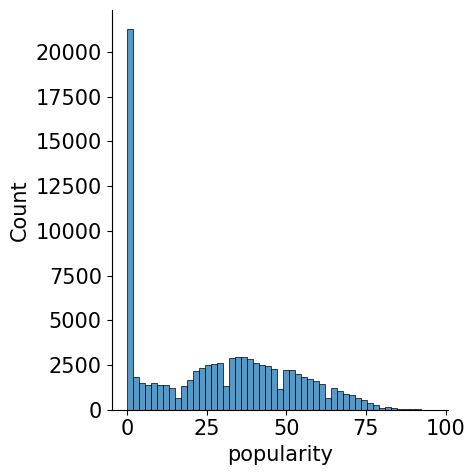

In [15]:
mpl.rc('font', size = 15)
sns.displot(train['popularity'])

/Users/potatodev/anaconda3/envs/aiml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/potatodev/anaconda3/envs/aiml/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


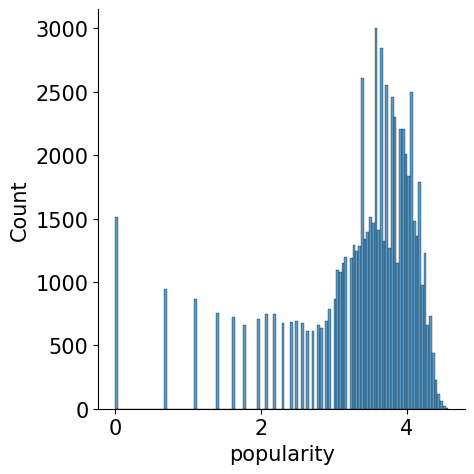

In [16]:
sns.displot(np.log(train['popularity']))

/Users/potatodev/anaconda3/envs/aiml/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


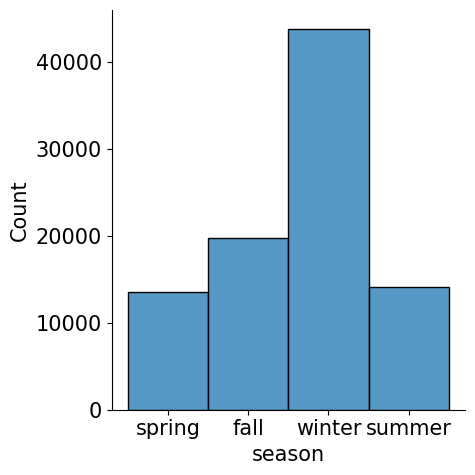

In [17]:
sns.displot(train['season'])

* 0   artists           91038 non-null  object 
*  1   acousticness      91038 non-null  float64
*  2   danceability      91038 non-null  float64
*  3   duration_ms       91038 non-null  int64  
*  4   energy            91038 non-null  float64
*  5   explicit          91038 non-null  int64  
*  6   instrumentalness  91038 non-null  float64
*  7   key               91038 non-null  int64  
*  8   liveness          91038 non-null  float64
*  9   loudness          91038 non-null  float64
*  10  mode              91038 non-null  int64  
*  11  speechiness       91038 non-null  float64
*  12  tempo             91038 non-null  float64
*  13  valence           91038 non-null  float64
*  14  popularity        91038 non-null  int64  
*  15  year              91038 non-null  int32  
*  16  month             91038 non-null  int32  
*  17  day               91038 non-null  int32  
*  18  season            91038 non-null  int64 

[Text(0.5, 1.0, 'duration_ms-popularity')]

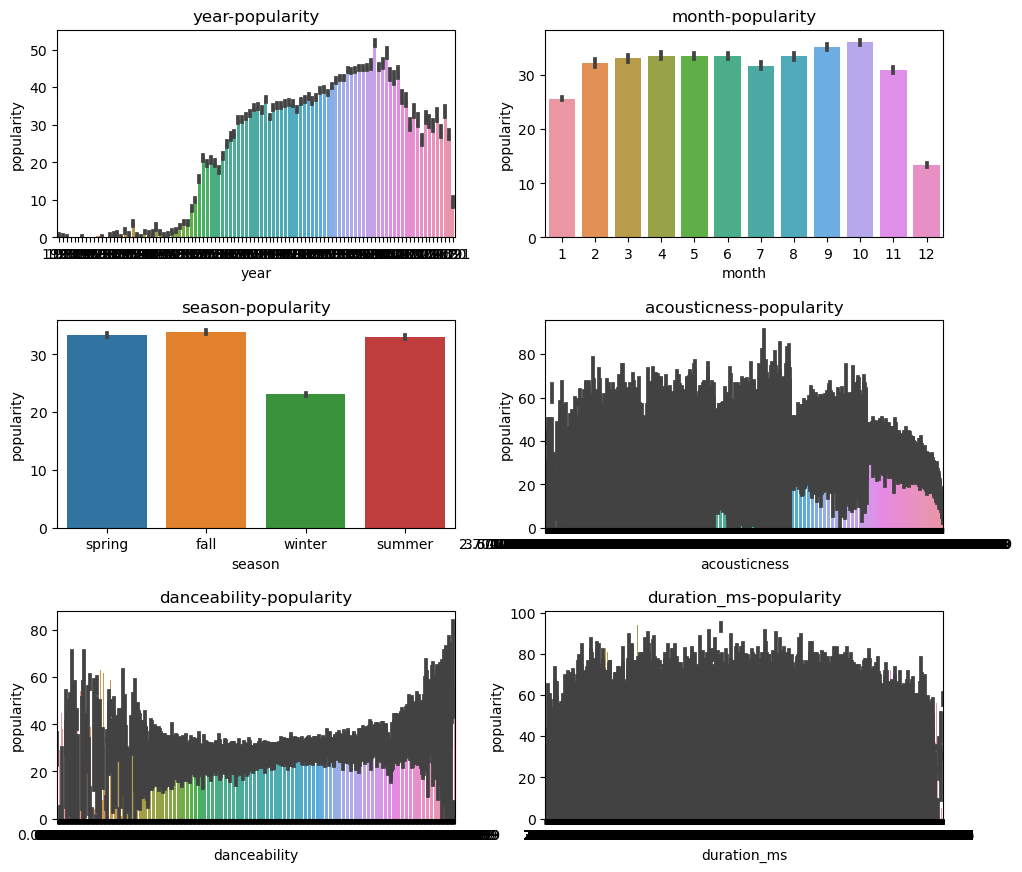

In [18]:
mpl.rc('font', size = 10)
mpl.rc('axes', titlesize = 12)
figure, axes = plt.subplots(nrows = 3, ncols = 2)
plt.tight_layout()
figure.set_size_inches(10, 9)

sns.barplot(x = 'year', y = 'popularity', data = train, ax = axes[0,0])
sns.barplot(x = 'month', y = 'popularity', data = train, ax = axes[0,1])
sns.barplot(x = 'season', y = 'popularity', data = train, ax = axes[1,0])
sns.barplot(x = 'acousticness', y = 'popularity', data = train, ax = axes[1,1])
sns.barplot(x = 'danceability', y = 'popularity', data = train, ax = axes[2,0])
sns.barplot(x = 'duration_ms', y = 'popularity', data = train, ax = axes[2,1])

axes[0,0].set(title = 'year-popularity')
axes[0,1].set(title = 'month-popularity')
axes[1,0].set(title = 'season-popularity')
axes[1,1].set(title = 'acousticness-popularity')
axes[2,0].set(title = 'danceability-popularity')
axes[2,1].set(title = 'duration_ms-popularity')